# Language in Space

## Session 08: Vector data operations (cont.); raster data

### Gerhard Jäger

December 16, 2021


In [1]:
options(repr.plot.width=12, repr.plot.height=9)


In [2]:
library(tidyverse)
library(sf)
library(spData)


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.0, GDAL 3.2.2, PROJ 7.2.1




## Spatial joining

In a regular join operation, two observations from the two tibbles involved are merged if they have the same value for the `by` column.

In *spatial joining*, we combine observations from `sf` objects based on their geometries. It has to be specified which geometric relation holds between them. The default is `st_intersects`.

### Example: Random points on a world map

In [3]:
# bounding box of 'world'

(bb_world = st_bbox(world))

      xmin       ymin       xmax       ymax 
-180.00000  -89.90000  179.99999   83.64513 

In [4]:
random_df = tibble(
  x = runif(n = 10, min = bb_world[1], max = bb_world[3]),
  y = runif(n = 10, min = bb_world[2], max = bb_world[4])
)
random_df

x,y
<dbl>,<dbl>
-20.717630,-44.0804977
28.068869,-48.0369322
-120.225017,31.2626126
152.430583,0.8350317
-170.259328,3.9985335
92.712325,50.2332787
-172.177284,-33.5184892
-147.498807,-85.9614137
-3.649367,-81.4409466


In [5]:
random_points = random_df %>% 
  st_as_sf(coords = c("x", "y")) %>% # set coordinates
  st_set_crs(4326) # set geographic CRS

random_points
 

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,geometry
,<POINT [°]>
1,POINT (-20.71763 -44.0805)
2,POINT (28.06887 -48.03693)
3,POINT (-120.225 31.26261)
4,POINT (152.4306 0.8350317)
5,POINT (-170.2593 3.998533)
6,POINT (92.71233 50.23328)
7,POINT (-172.1773 -33.51849)
8,POINT (-147.4988 -85.96141)
9,POINT (-3.649367 -81.44095)


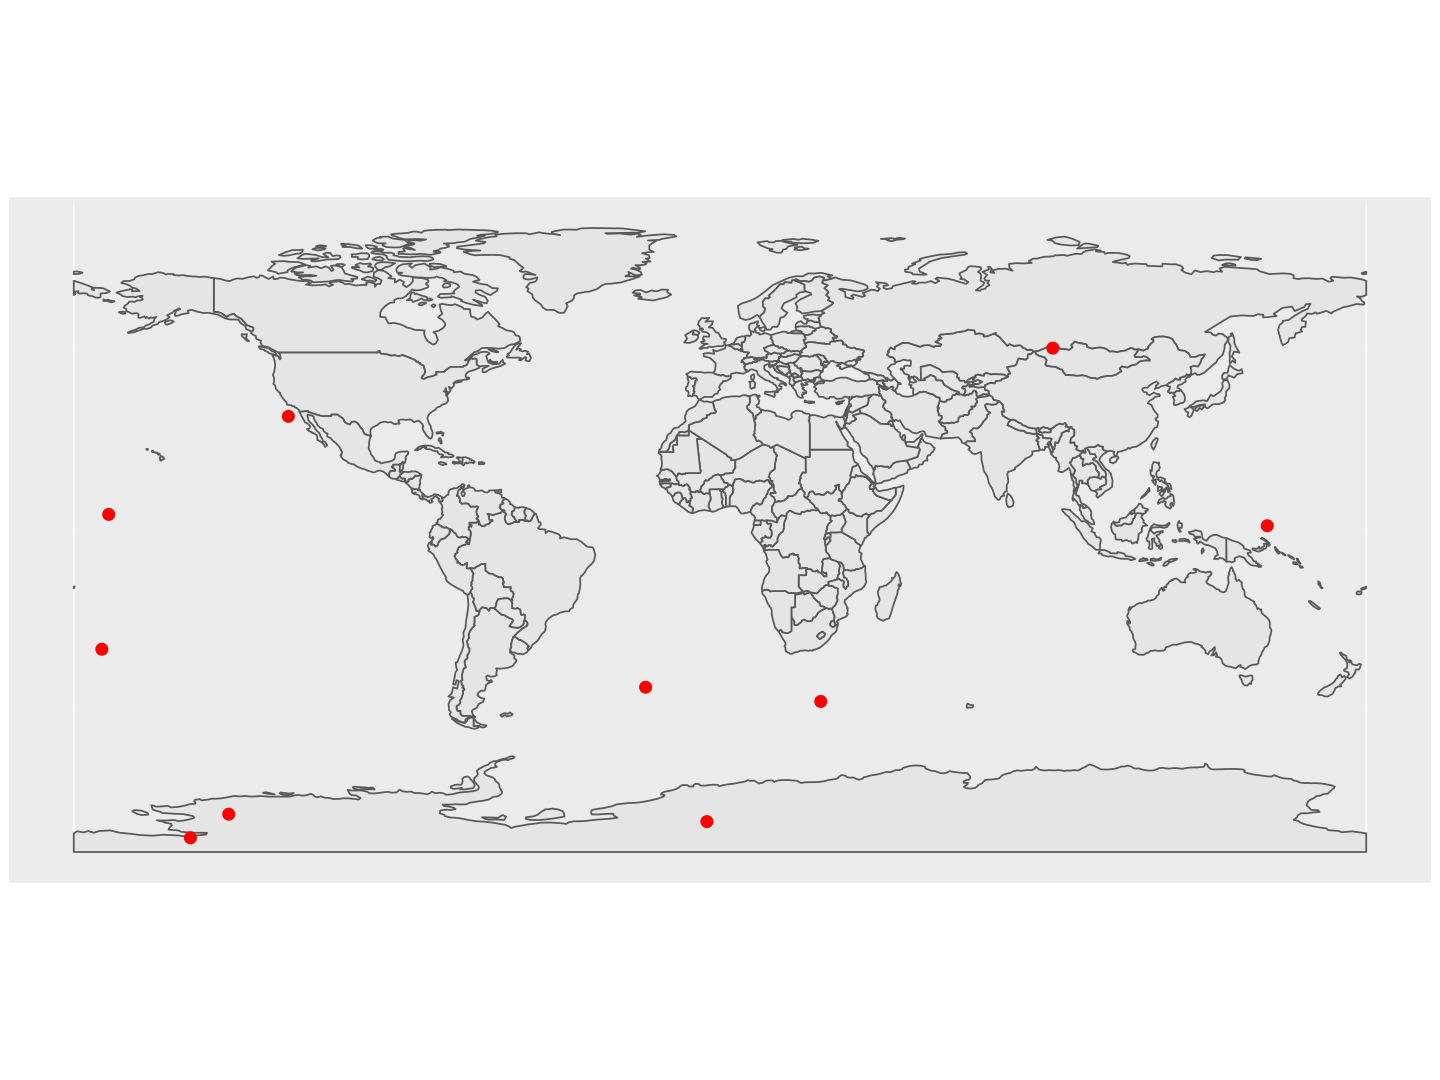

In [6]:
world %>% 
    ggplot() +
    geom_sf() +
    geom_sf(data=random_points, color='red', size=3)


In [7]:
random_points %>%
    st_join(world) 


,geometry,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap
,<POINT [°]>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,POINT (-20.71763 -44.0805),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,POINT (28.06887 -48.03693),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,POINT (-120.225 31.26261),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,POINT (152.4306 0.8350317),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,POINT (-170.2593 3.998533),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,POINT (92.71233 50.23328),MN,Mongolia,Asia,Asia,Eastern Asia,Sovereign country,1544322,2923896,68.847,11348.65
7,POINT (-172.1773 -33.51849),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,POINT (-147.4988 -85.96141),AQ,Antarctica,Antarctica,Antarctica,Antarctica,Indeterminate,12335956,NA,NA,NA
9,POINT (-3.649367 -81.44095),AQ,Antarctica,Antarctica,Antarctica,Antarctica,Indeterminate,12335956,NA,NA,NA


In [8]:
countries_with_point <- random_points %>%
    st_join(world, left=F) %>%
    pull(iso_a2)

countries_with_point

[1] "MN" "AQ" "AQ" "AQ"

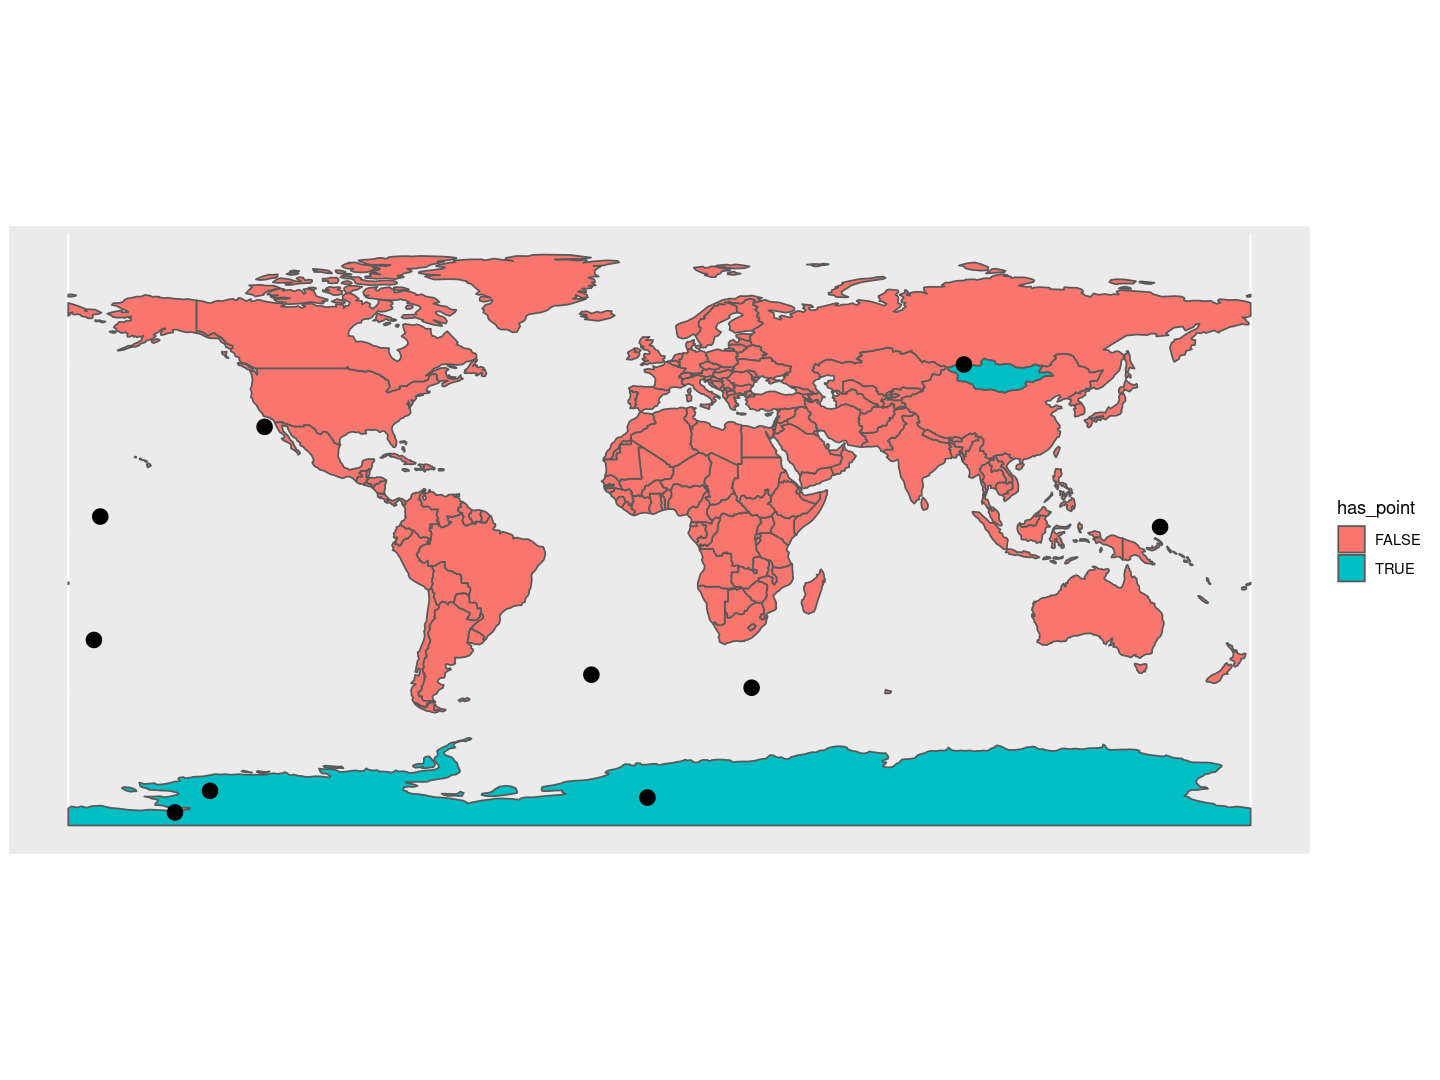

In [9]:
world %>% 
    mutate(has_point = iso_a2 %in% countries_with_point) %>%
    ggplot() +
    geom_sf(aes(fill=has_point)) +
    geom_sf(data=random_points, size=4)


## Spatial joining with non-overlapping data

Sometimes one wants to spatially join data where the spatial information is not identical but overlapping (e.g., due to measurement errors or different precision levels).

Consider the following two datasets from `spData`:

In [10]:
cycle_hire %>% 
    slice_sample(n=10)

id,name,area,nbikes,nempty,geometry
<int>,<fct>,<fct>,<int>,<int>,<POINT [°]>
17,Hatton Wall,Holborn,4,22,POINT (-0.1090063 51.52166)
146,Vauxhall Bridge,Pimlico,32,3,POINT (-0.1293618 51.48837)
87,Devonshire Square,Liverpool Street,0,16,POINT (-0.07968456 51.51647)
699,Belford House,Haggerston,22,17,POINT (-0.07023031 51.53665)
427,Cheapside,Bank,6,37,POINT (-0.09294031 51.51397)
640,Silverthorne Road,Battersea,19,9,POINT (-0.1480593 51.47287)
263,St. Mary Axe,Aldgate,0,19,POINT (-0.08066008 51.51423)
127,Wood Street,Guildhall,0,16,POINT (-0.09388536 51.51701)
196,Union Street,The Borough,13,3,POINT (-0.09849768 51.50369)


In [11]:
cycle_hire_osm %>%
    slice_sample(n=10)

osm_id,name,capacity,cyclestreets_id,description,geometry
<fct>,<fct>,<dbl>,<fct>,<fct>,<POINT [°]>
1818789625,"York Hall, Bethnal Green",15,NA,NA,POINT (-0.0558838 51.52899)
3196013350,NA,29,NA,NA,POINT (-0.0155911 51.52515)
820945916,Drury Lane,17,NA,NA,POINT (-0.122162 51.51474)
885331209,"Kensington, Wright's Lane",27,NA,NA,POINT (-0.1930058 51.50032)
1176800594,"Knightsbridge, Prince Consort Road",8,NA,NA,POINT (-0.1763095 51.49977)
973101833,NA,16,NA,NA,POINT (-0.0900262 51.5178)
859408757,Union Street,NA,NA,NA,POINT (-0.0984831 51.50367)
1012775602,"The Borough, Harper Road",32,NA,NA,POINT (-0.0962169 51.4986)
4692553573,NA,NA,NA,NA,POINT (-0.0417247 51.52248)


Check compatibility:

In [12]:
cycle_hire %>%
    st_crs()

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]

In [13]:
cycle_hire_osm %>%
    st_crs()

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]

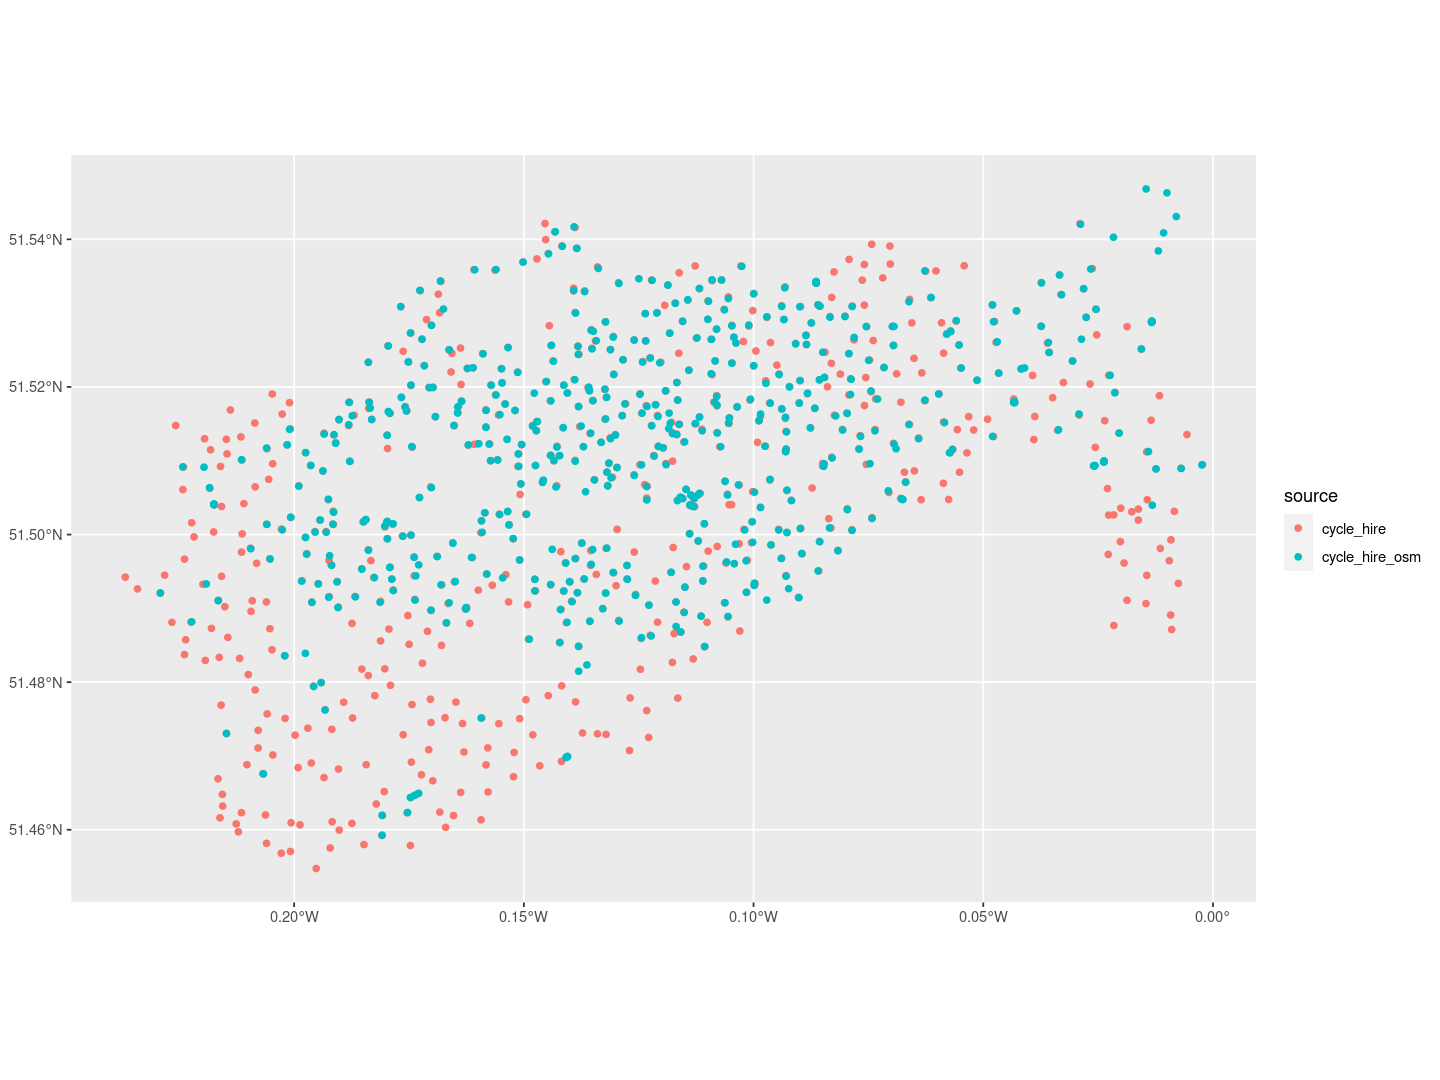

In [14]:
t1 <- cycle_hire %>%
    select(geometry) %>%
    mutate(source="cycle_hire")

t2 <- cycle_hire_osm %>%
    select(geometry) %>%
    mutate(source="cycle_hire_osm")

t1 %>%
    rbind(t2) %>%
    ggplot() +
    geom_sf(aes(col=source))

In [15]:
t1 %>% 
    st_join(t2, left=F)

source.x,source.y,geometry
<chr>,<chr>,<GEOMETRY [°]>


The points from the two datasets are disjoint.

Suppose we want to add the `capacity` information from `cycle_hire_osm` to `cycle_hire`. We can do so by defining a threshold distance and then apply spatial joining.



In [16]:
cycle_hire_P = st_transform(cycle_hire, 27700)
cycle_hire_osm_P = st_transform(cycle_hire_osm, 27700)


cycle_hire_P %>%
    st_crs()

Coordinate Reference System:
  User input: EPSG:27700 
  wkt:
PROJCRS["OSGB 1936 / British National Grid",
    BASEGEOGCRS["OSGB 1936",
        DATUM["OSGB 1936",
            ELLIPSOID["Airy 1830",6377563.396,299.3249646,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4277]],
    CONVERSION["British National Grid",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",49,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-2,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996012717,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",400000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER

In [17]:
cycle_hire_P %>%
    st_join(cycle_hire_osm_P, join = st_is_within_distance, dist = 20) %>%
    group_by(id) %>%
    summarize(capacity = mean(capacity, na.rm=T)) %>%
    st_drop_geometry() %>%
    inner_join(cycle_hire_P) %>%
    slice_sample(n=20)

Joining, by = "id"



id,capacity,name,area,nbikes,nempty,geometry
<int>,<dbl>,<fct>,<fct>,<int>,<int>,<POINT [m]>
762,NaN,Storey's Gate,Westminster,8,13,POINT (529916 179632)
619,NaN,Irene Road,Parsons Green,13,30,POINT (525318 176519)
22,9,Northington Street,Holborn,2,16,POINT (530938.3 182057.5)
174,26,Strand,Strand,12,22,POINT (530891 180973)
31,NaN,Fanshaw Street,Hoxton,21,13,POINT (533048.6 182921.6)
214,22,Endsleigh Gardens,Euston,21,11,POINT (529785.9 182536.9)
110,7,Wellington Road,St. John's Wood,10,7,POINT (526853.6 183153.3)
177,15,Ashley Place,Victoria,17,8,POINT (529148.1 179107)
244,3,Earnshaw Street,Covent Garden,0,17,POINT (529949.5 181348.3)


## Voronoi tesselation

- partition of the plane into disjoint regions
- generated by a finite set of points
- to each generator point, the corresponding region consist of the set of points which are closer to it than to any other generator point
- *closer* here means *smaller Euclidean distance*

- implemented in `sf`-function `sp_voronoi*

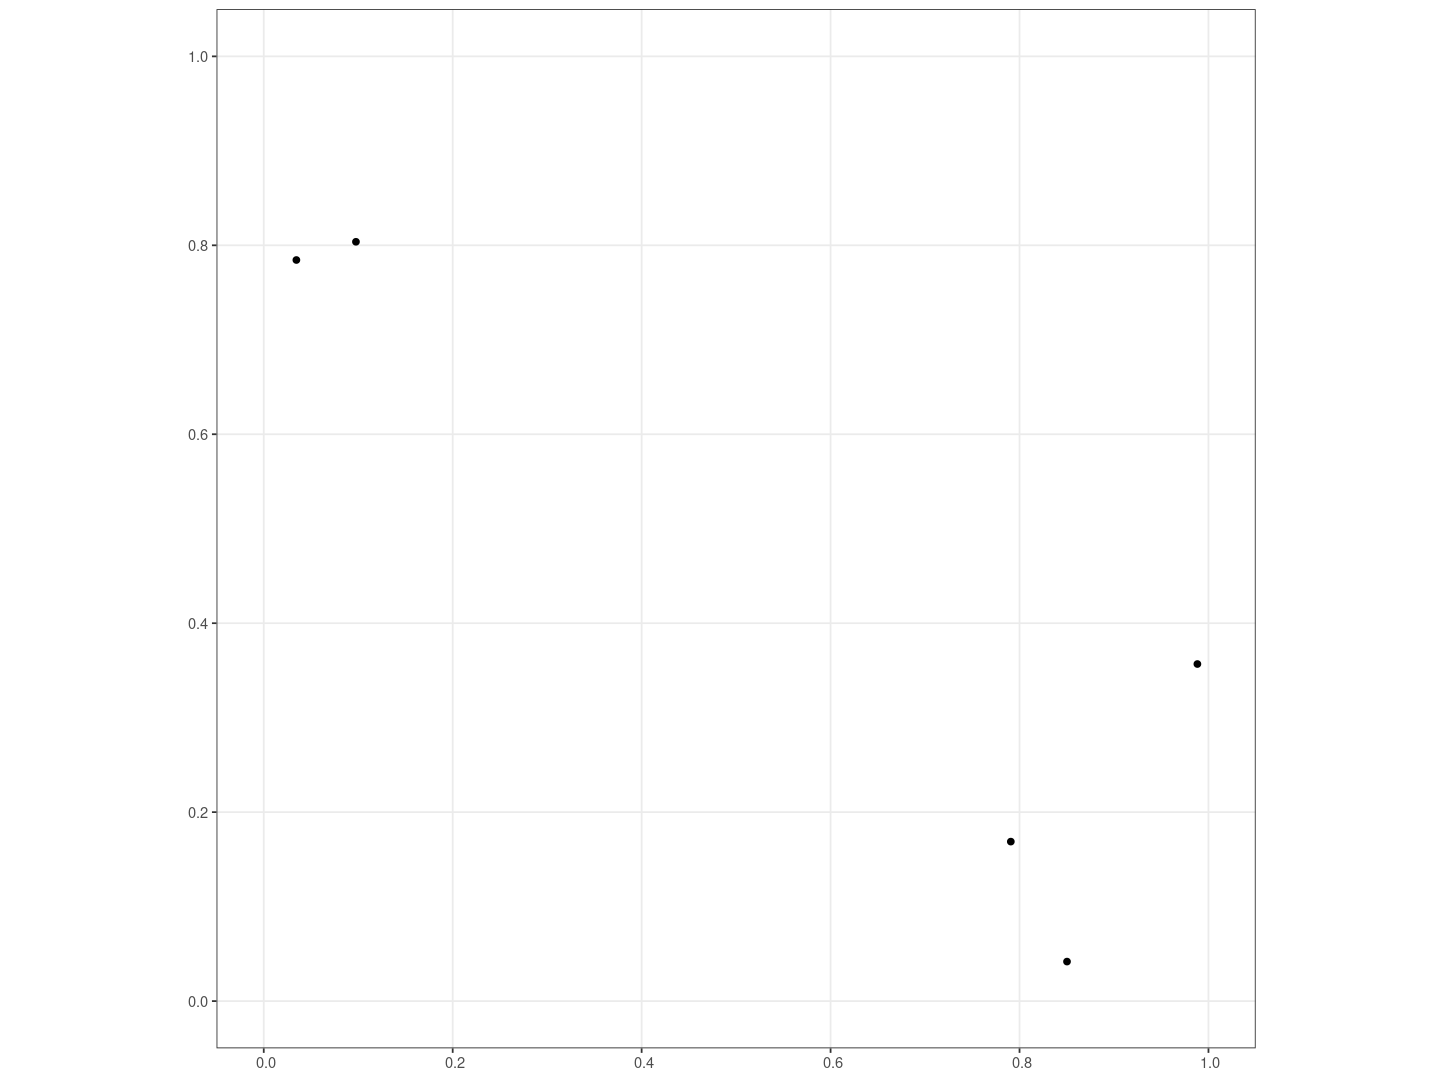

In [18]:
nPoints <- 5

x = runif(nPoints)
y = runif(nPoints)
df = tibble(
    name = paste("p", str_pad(1:nPoints, 2, pad="0"), sep=""),
    x=x,
    y=y
)
points = st_as_sf(df, coords = c("x", "y"))

points %>%
    ggplot() +
    theme_bw() +
    geom_sf() +
    xlim(0,1) + ylim(0,1)

In [19]:
v <- points %>% 
    st_geometry() %>%
    st_coordinates() %>%
    st_multipoint() %>%
    st_voronoi() 
v

GEOMETRYCOLLECTION (POLYGON ((-0.9191967 1.757464, -0.2285798 1.757464, 0.2312986 0.2538363, -0.3272467 -0.4322676, -0.7639314 -0.9119288, -0.9191967 -0.9119288, -0.9191967 1.757464)), POLYGON ((-0.3272467 -0.4322676, 0.9719402 0.1762156, 1.942005 -0.2488173, 1.942005 -0.9119288, -0.7639314 -0.9119288, -0.3272467 -0.4322676)), POLYGON ((0.5582559 0.6107939, 0.2312986 0.2538363, -0.2285798 1.757464, 1.133661 1.757464, 0.5582559 0.6107939)), POLYGON ((-0.3272467 -0.4322676, 0.2312986 0.2538363, 0.5582559 0.6107939, 0.9719402 0.1762156, -0.3272467 -0.4322676)), POLYGON ((0.9719402 0.1762156, 0.5582559 0.6107939, 1.133661 1.757464, 1.942005 1.757464, 1.942005 -0.2488173, 0.9719402 0.1762156)))



`st_voronoi` returns a geometry collection. A hack is needed to convert it into a `sfc`.

In [20]:
v_sfc <- v %>%
    lapply(function(x) x) %>%
    st_sfc()
           
v_sfc

POLYGON ((-0.9191967 1.757464, -0.2285798 1.757...

POLYGON ((-0.3272467 -0.4322676, 0.9719402 0.17...

POLYGON ((0.5582559 0.6107939, 0.2312986 0.2538...

POLYGON ((-0.3272467 -0.4322676, 0.2312986 0.25...

POLYGON ((0.9719402 0.1762156, 0.5582559 0.6107...



Geometry set for 5 features 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -0.9191967 ymin: -0.9119288 xmax: 1.942005 ymax: 1.757464
CRS:           NA

In [21]:
regions <- tibble(
    name = points$name
) %>%
    st_sf(geometry=v_sfc)

regions

,name,geometry
,<chr>,<POLYGON>
1,p01,POLYGON ((-0.9191967 1.7574...
2,p02,POLYGON ((-0.3272467 -0.432...
3,p03,POLYGON ((0.5582559 0.61079...
4,p04,POLYGON ((-0.3272467 -0.432...
5,p05,POLYGON ((0.9719402 0.17621...


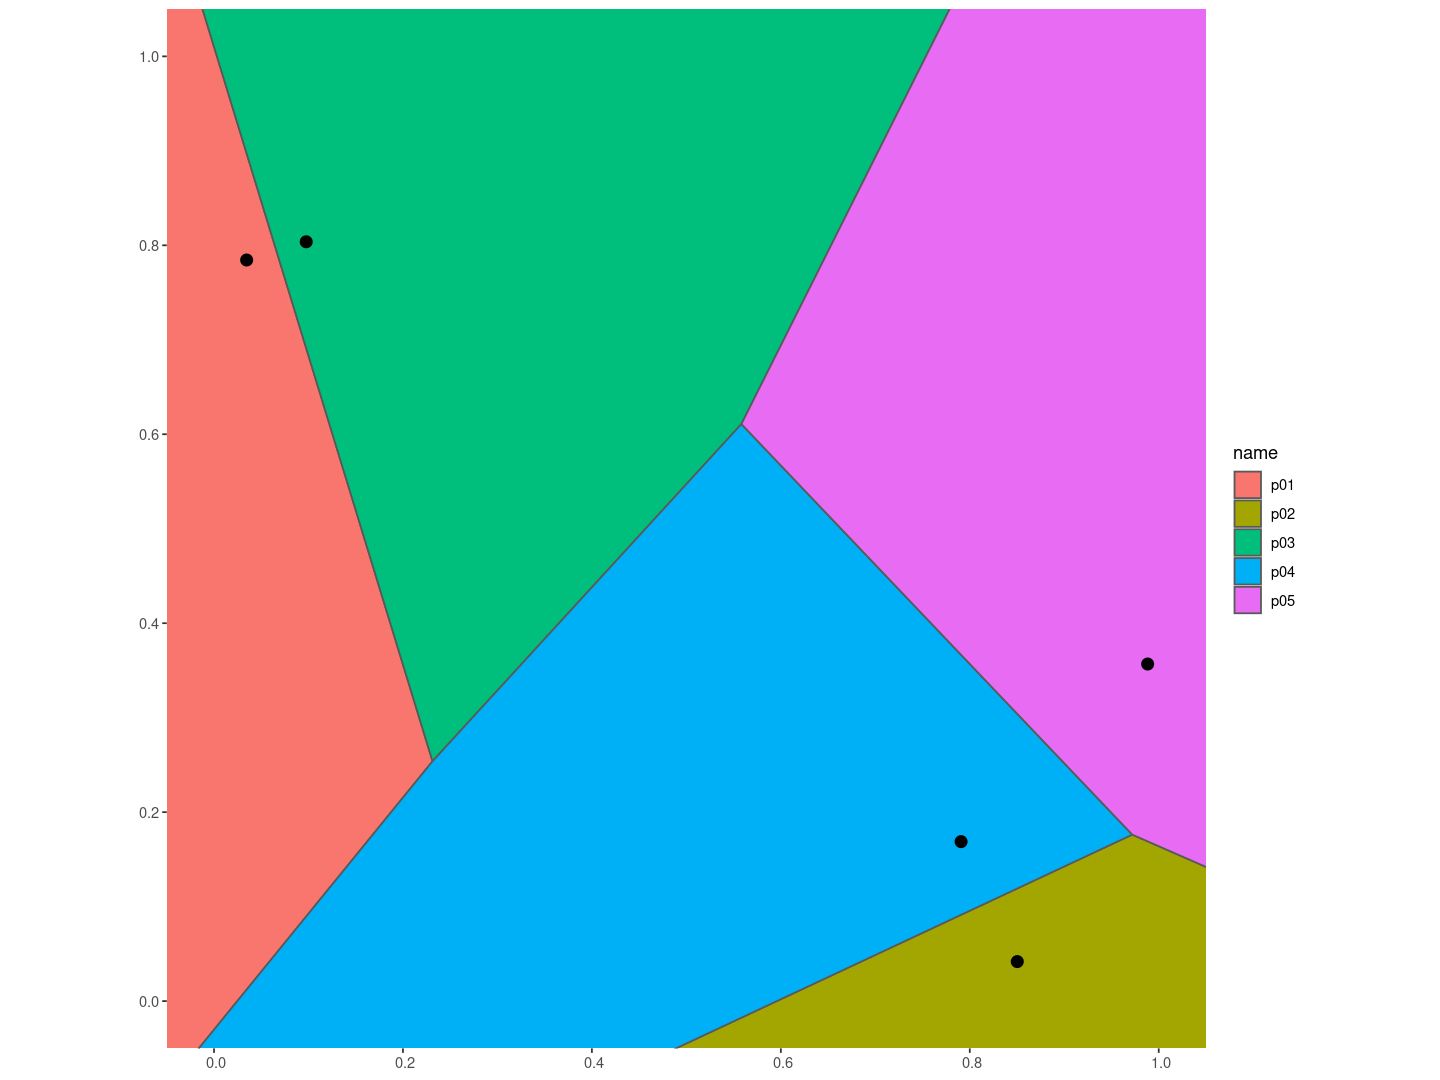

In [22]:
regions %>%
    ggplot() +
    geom_sf(aes(fill=name)) +
    geom_sf(data=points, size=3) +
    xlim(0,1) + ylim(0,1) 

**BUT!!!**

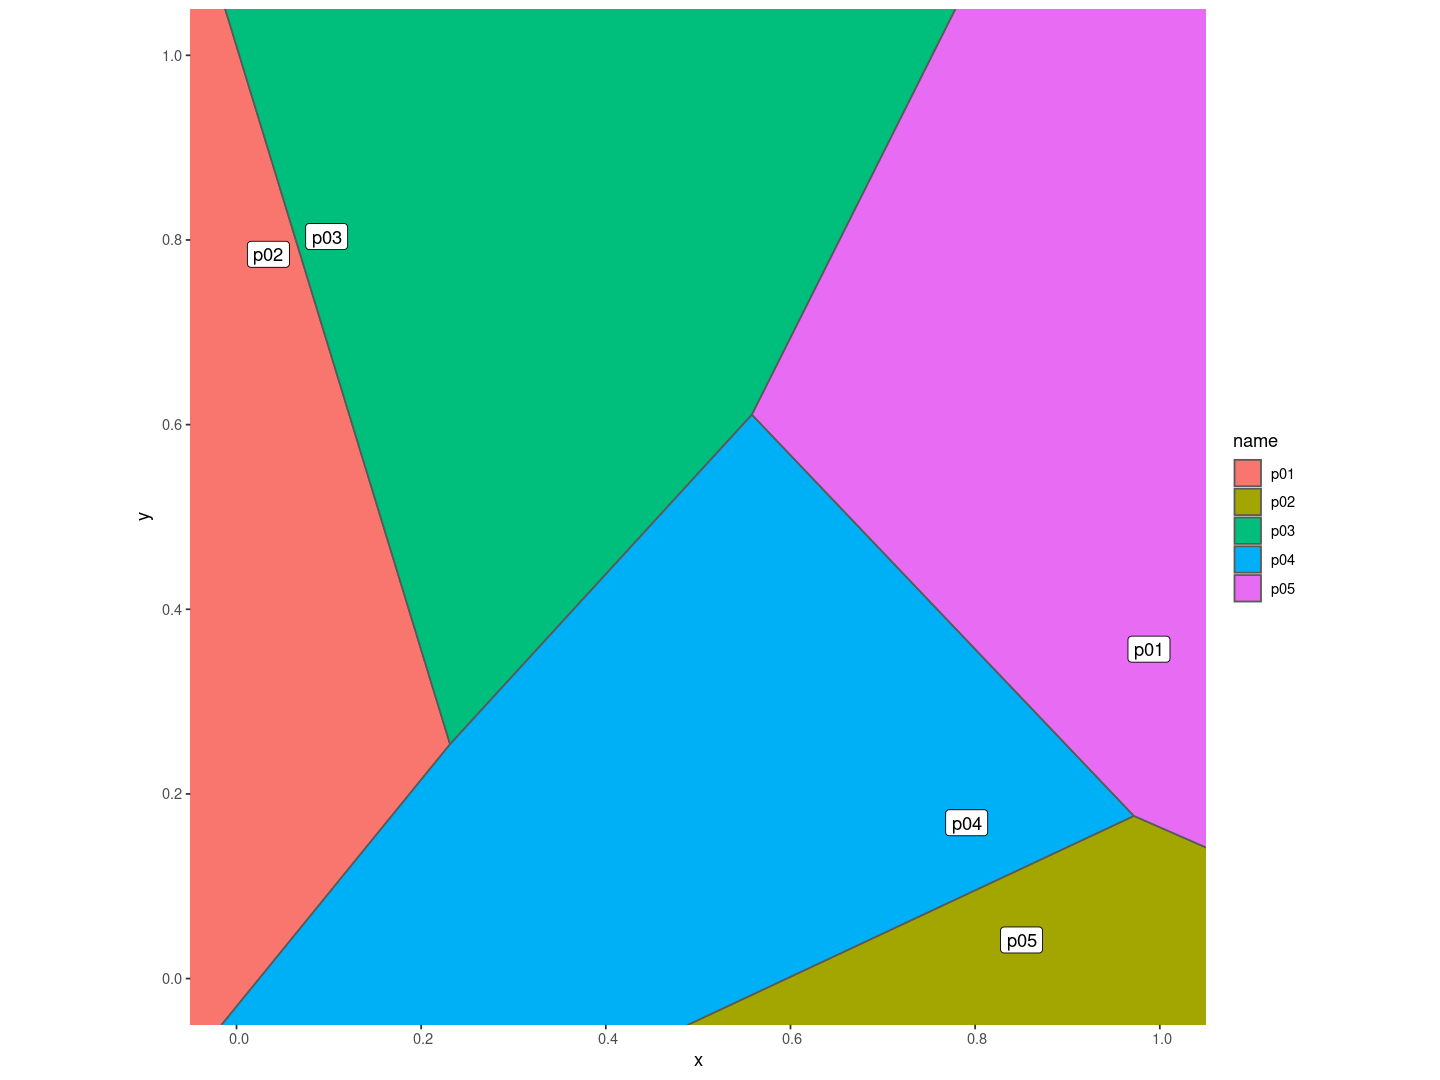

In [23]:
regions %>%
    ggplot() +
    geom_sf(aes(fill=name)) +
    geom_sf(data=points) +
    xlim(0,1) + ylim(0,1) +
    geom_sf_label(data=points,aes(label=name))


`st_voronoi` does not preserve the order of the generator points!

To correctly match points and regions, we need a spatial joint.

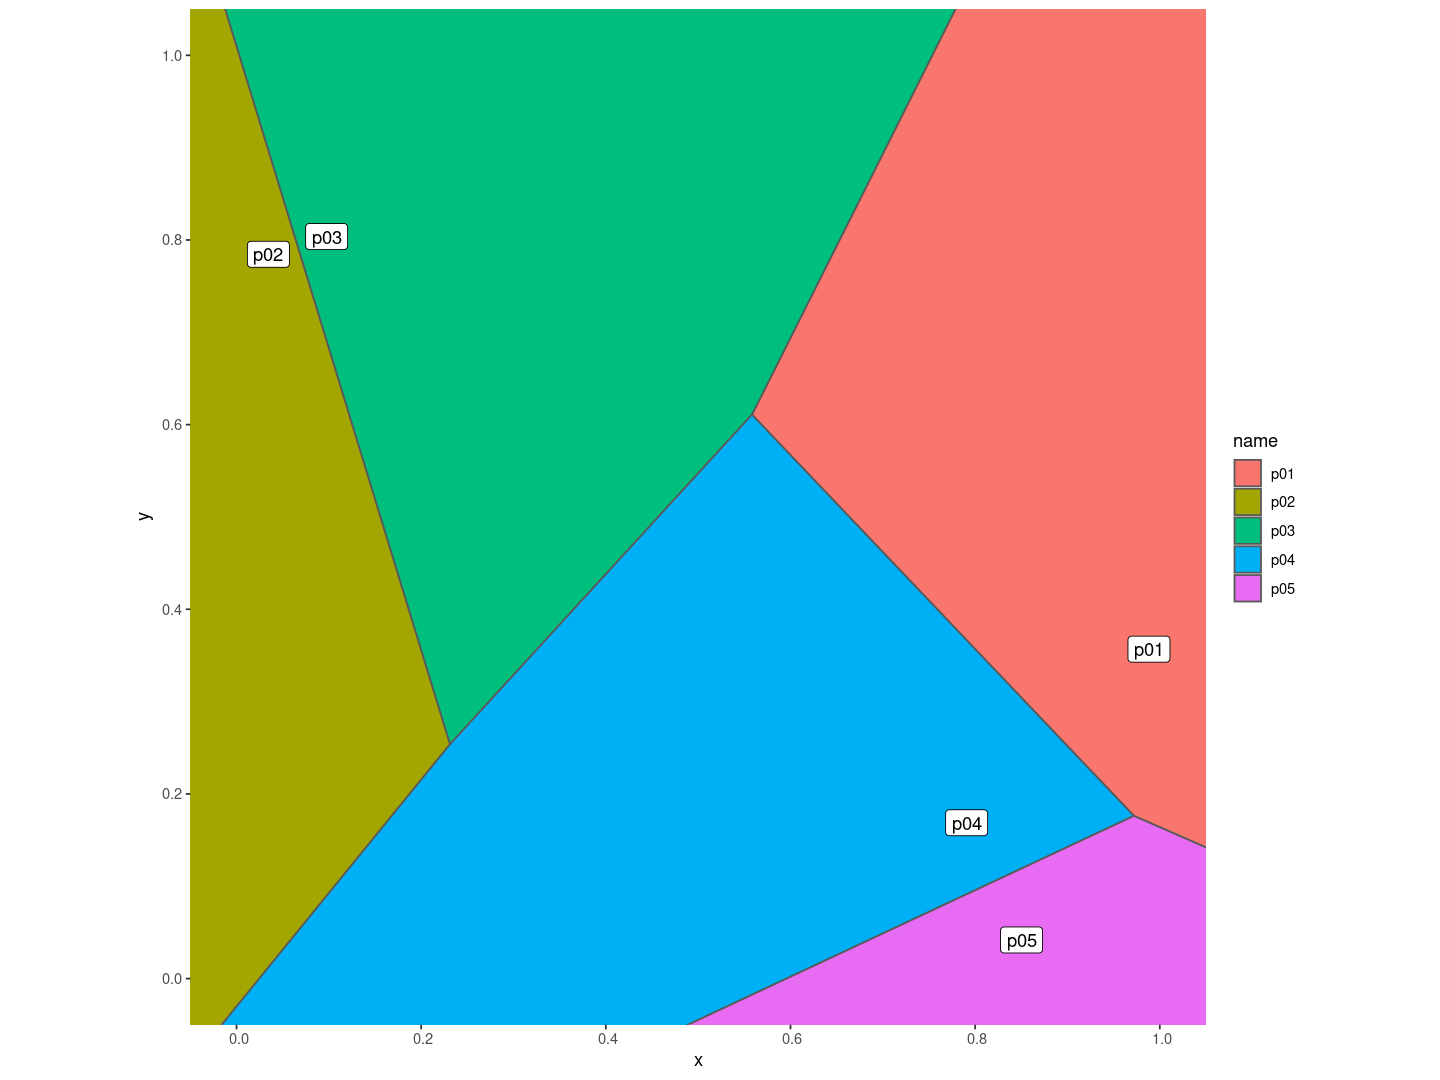

In [24]:
regions %>%
    select(!name) %>%
    st_join(points) %>%
    ggplot() +
    geom_sf(aes(fill=name)) +
    geom_sf(data=points) +
    xlim(0,1) + ylim(0,1) +
    geom_sf_label(data=points,aes(label=name))

## Reading and writing vector data to/from disk

There is a wide variety of file formats for storing vector geometries. In many cases, they can be retrieved via `read_sf`. 

The most common file format is a **shapefile**. 

Somewhat confusingly, a shapefile is actually not a single file, but a collection of files with the same basename which reside in the same directory. Mandatory files are (info from Wikipedia):

- .shp — shape format; the feature geometry itself {content-type: x-gis/x-shapefile}
- .shx — shape index format; a positional index of the feature geometry to allow seeking forwards and backwards quickly {content-type: x-gis/x-shapefile}
- .dbf — attribute format; columnar attributes for each shape, in dBase IV format {content-type: application/octet-stream OR text/plain}



Optionally, the following files can be present:

- .prj — projection description, using a well-known text representation of coordinate reference systems {content-type: text/plain OR application/text}
- .sbn and .sbx — a spatial index of the features {content-type: x-gis/x-shapefile}
- .fbn and .fbx — a spatial index of the features that are read-only {content-type: x-gis/x-shapefile}
- .ain and .aih — an attribute index of the active fields in a table {content-type: x-gis/x-shapefile}
- .ixs — a geocoding index for read-write datasets {content-type: x-gis/x-shapefile}
- .mxs — a geocoding index for read-write datasets (ODB format) {content-type: x-gis/x-shapefile}
- .atx — an attribute index for the .dbf file in the form of shapefile.columnname.atx (ArcGIS 8 and later) {content-type: x-gis/x-shapefile }
- .shp.xml — geospatial metadata in XML format, such as ISO 19115 or other XML schema {content-type: application/fgdc+xml}
- .cpg — used to specify the code page (only for .dbf) for identifying the character encoding to be used {content-type: text/plain OR x-gis/x-shapefile }
- .qix — an alternative quadtree spatial index used by MapServer and GDAL/OGR software {content-type: x-gis/x-shapefile}

The `.shp` file is the main file which is named when reading in data.

In [25]:
german_districts <- read_sf("data/germany_districts/germany_districts.shp")


Vector data can be written to disk in many common formats using `write_sf`. Based on the filename extension, the function decides automatically which driver to use.

# Working with raster data

Next to vector data, **raster data** is a standard data format for geospatial computation. 

![Image from saylordotorg.github.io](img/layers.png)

In this course, we will use the R-package `terra` to manipulate raster data.

In [26]:
library(terra)

terra version 1.4.15


Attaching package: ‘terra’


The following object is masked from ‘package:dplyr’:

    src


The following object is masked from ‘package:tidyr’:

    extract




A raster object is essentially a list of two-dimensional arrays of equal size.

The two dimensions represent the two spatial dimensions. The list elements are *layers*.
The layers are stored as a collection of 1-dimensional vectors.

Additionally, a raster object contains information about 
- a coordinate reference system (CRS)
- the number of rows and columns
- the location of the upper left corner within the CRS
- the size of the pixels



In [27]:
elev = rast(nrows = 6, ncols = 6, resolution = 0.5, 
            xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
            vals = 36:1)

elev

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : lyr.1 
min value   :     1 
max value   :    36 

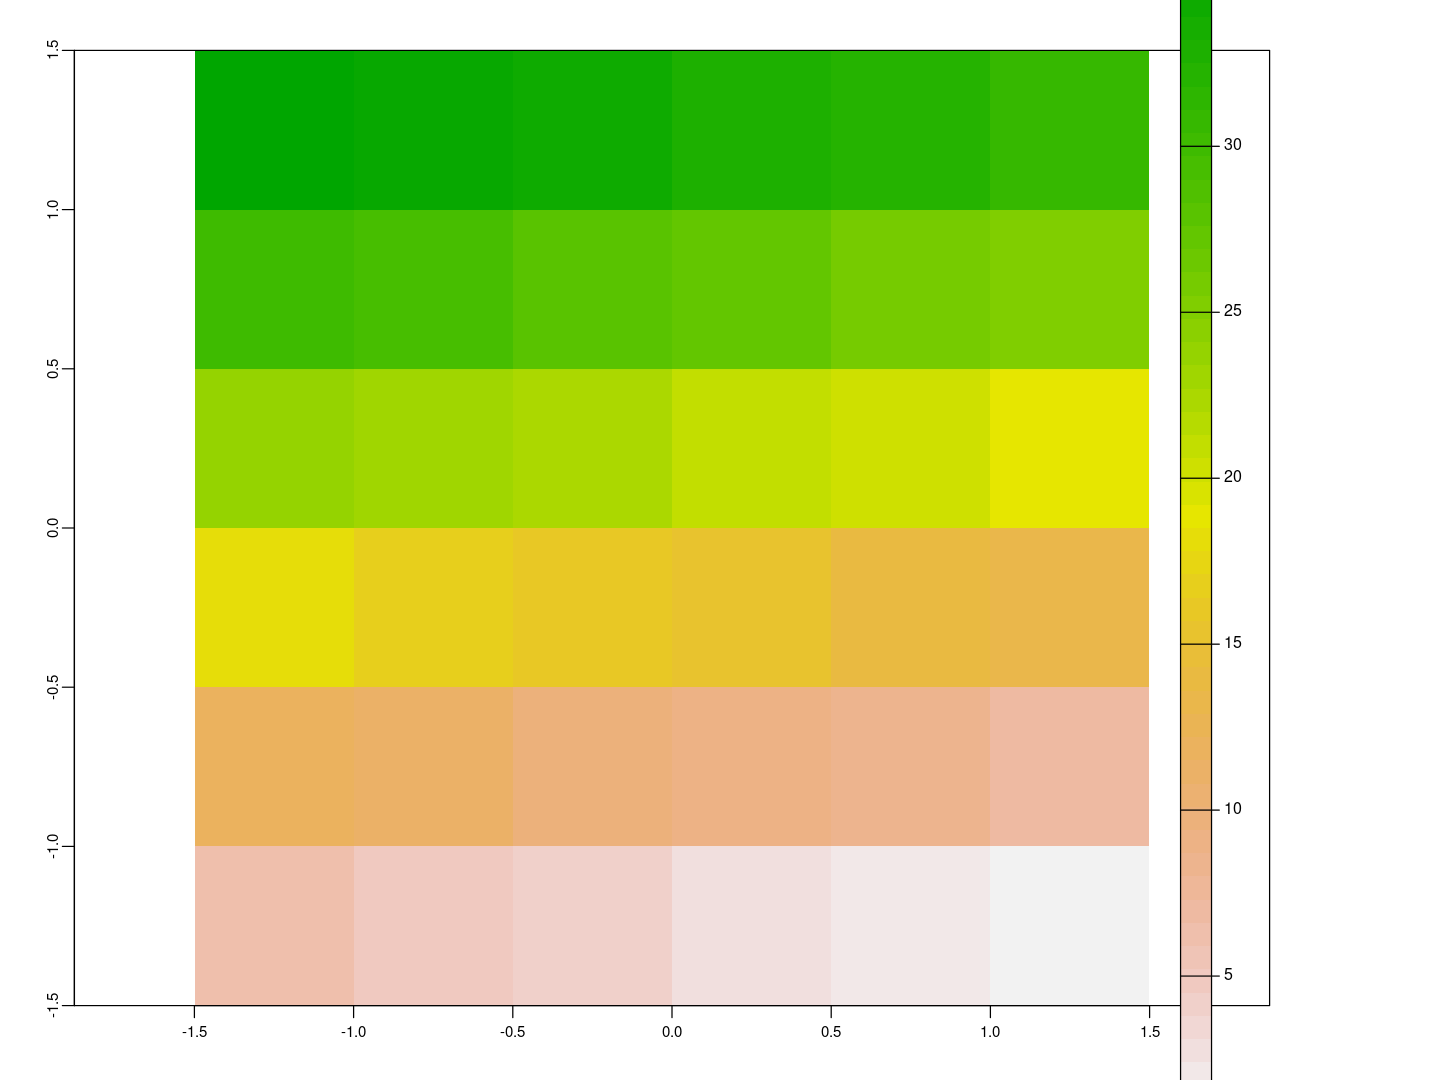

In [28]:
plot(elev)


In [29]:

grain_order = c("clay", "silt", "sand")
grain_char = sample(grain_order, 36, replace = TRUE)
grain_fact = factor(grain_char, levels = grain_order)
grain = rast(nrows = 6, ncols = 6, resolution = 0.5, 
             xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
             vals = grain_fact)


two_layers = c(grain, elev) 
names(two_layers) <- c("grain", "elev")


In [30]:

two_layers

class       : SpatRaster 
dimensions  : 6, 6, 2  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
sources     : memory  
              memory  
names       : grain, elev 
min values  :  clay,    1 
max values  :  silt,   36 

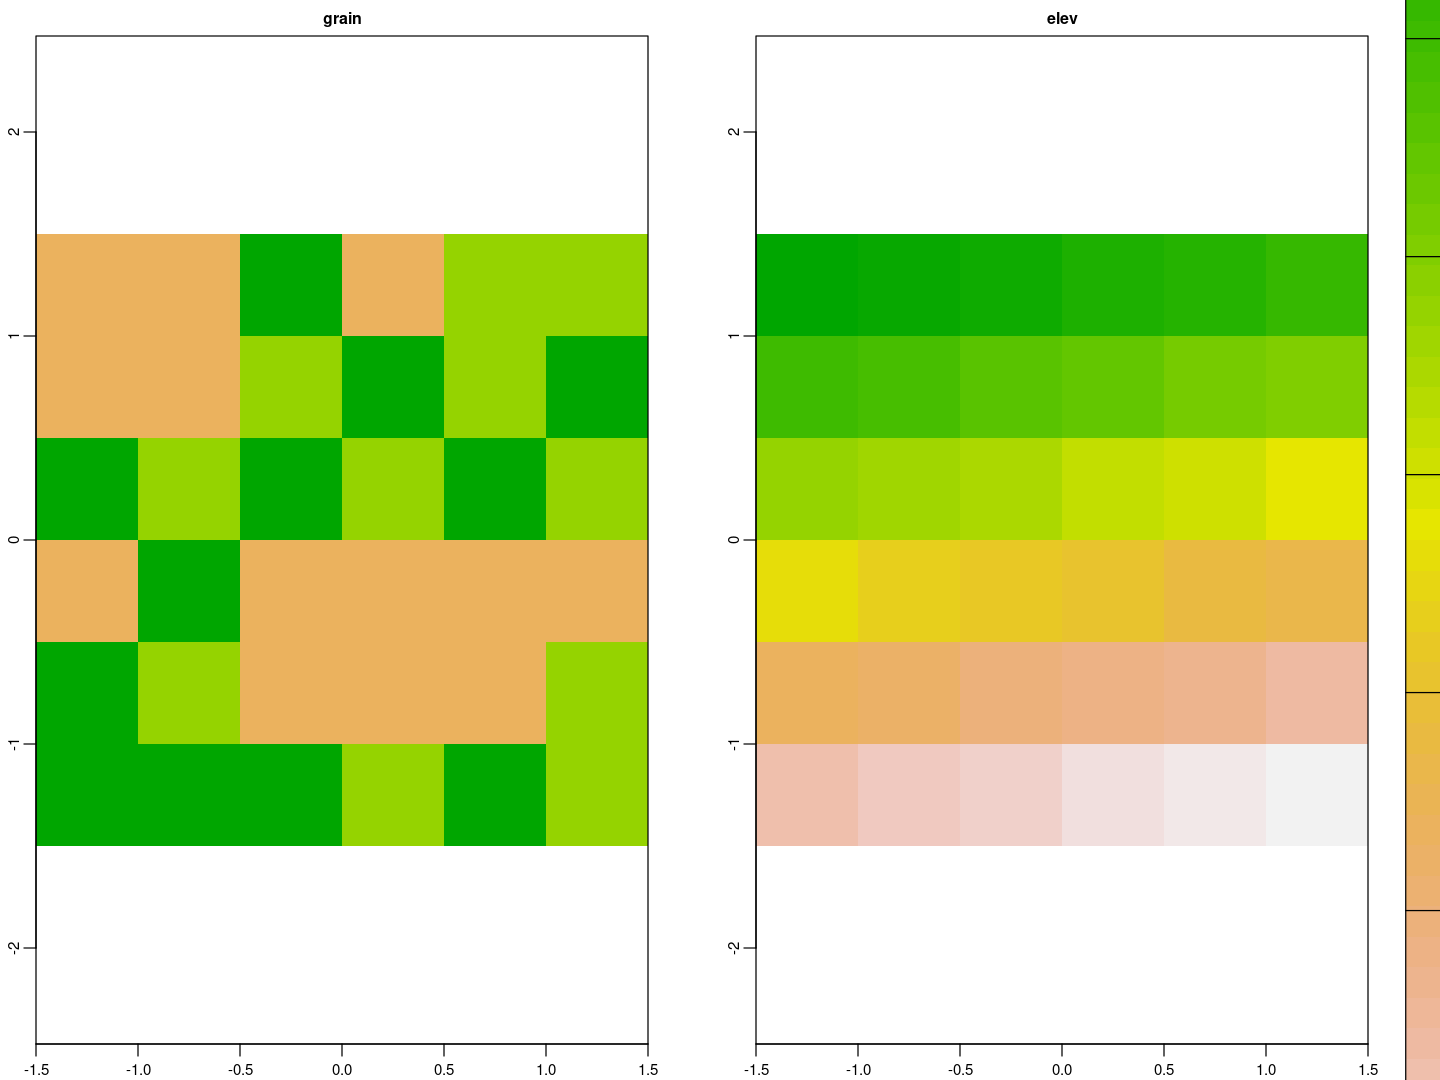

In [31]:
two_layers %>%
    plot()

## Retrieving values from a raster object



<img src="img/pixel.svg" alt="drawing" width="400"/>


If we know the pixel index of an object, we can simply use `R`'s indexing mechanism

In [32]:
elev[4,3]

lyr.1
<dbl>
16


If we only know the coordinates within the CRS, we can use `terra`'s function `cellFromXY`.

In [33]:
(id = cellFromXY(elev, matrix(c(-0.2, -0.2), ncol=2)))



[1] 21

In [34]:
elev[id]

lyr.1
<dbl>
16


## Raster-vector cropping

(example from https://geocompr.robinlovelace.net/geometric-operations.html#geo-ras)

Two objects:
- A `SpatRaster` object `srtm` representing elevation (meters above sea level) in south-western Utah.
- A vector (`sf`) object zion representing Zion National Park.



In [35]:
install.packages("spDataLarge", repos = "https://geocompr.r-universe.dev")


Installing package into ‘/home/gjaeger/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [36]:
library(spDataLarge)


Attaching package: ‘spDataLarge’


The following object is masked _by_ ‘.GlobalEnv’:

    random_points




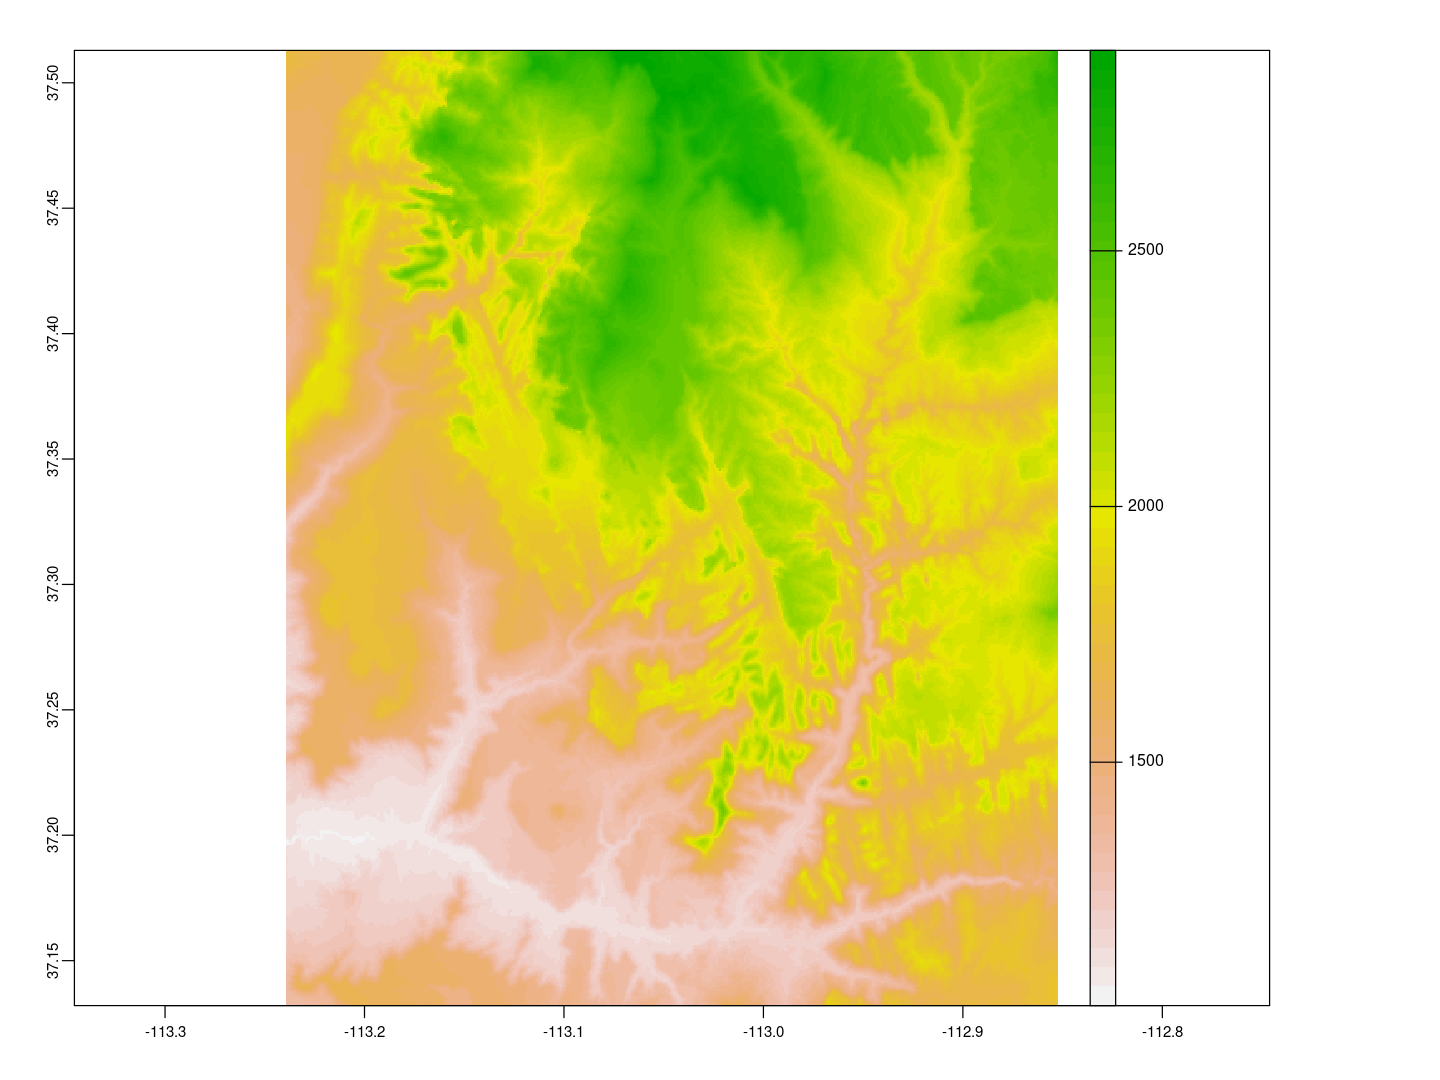

In [37]:
srtm = rast(system.file("raster/srtm.tif", package = "spDataLarge"))

plot(srtm)


Reading layer `zion' from data source 
  `/home/gjaeger/R/x86_64-pc-linux-gnu-library/4.0/spDataLarge/vector/zion.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 11 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 302903.1 ymin: 4112244 xmax: 334735.5 ymax: 4153087
Projected CRS: UTM Zone 12, Northern Hemisphere


Warning message:
“plotting the first 9 out of 11 attributes; use max.plot = 11 to plot all”


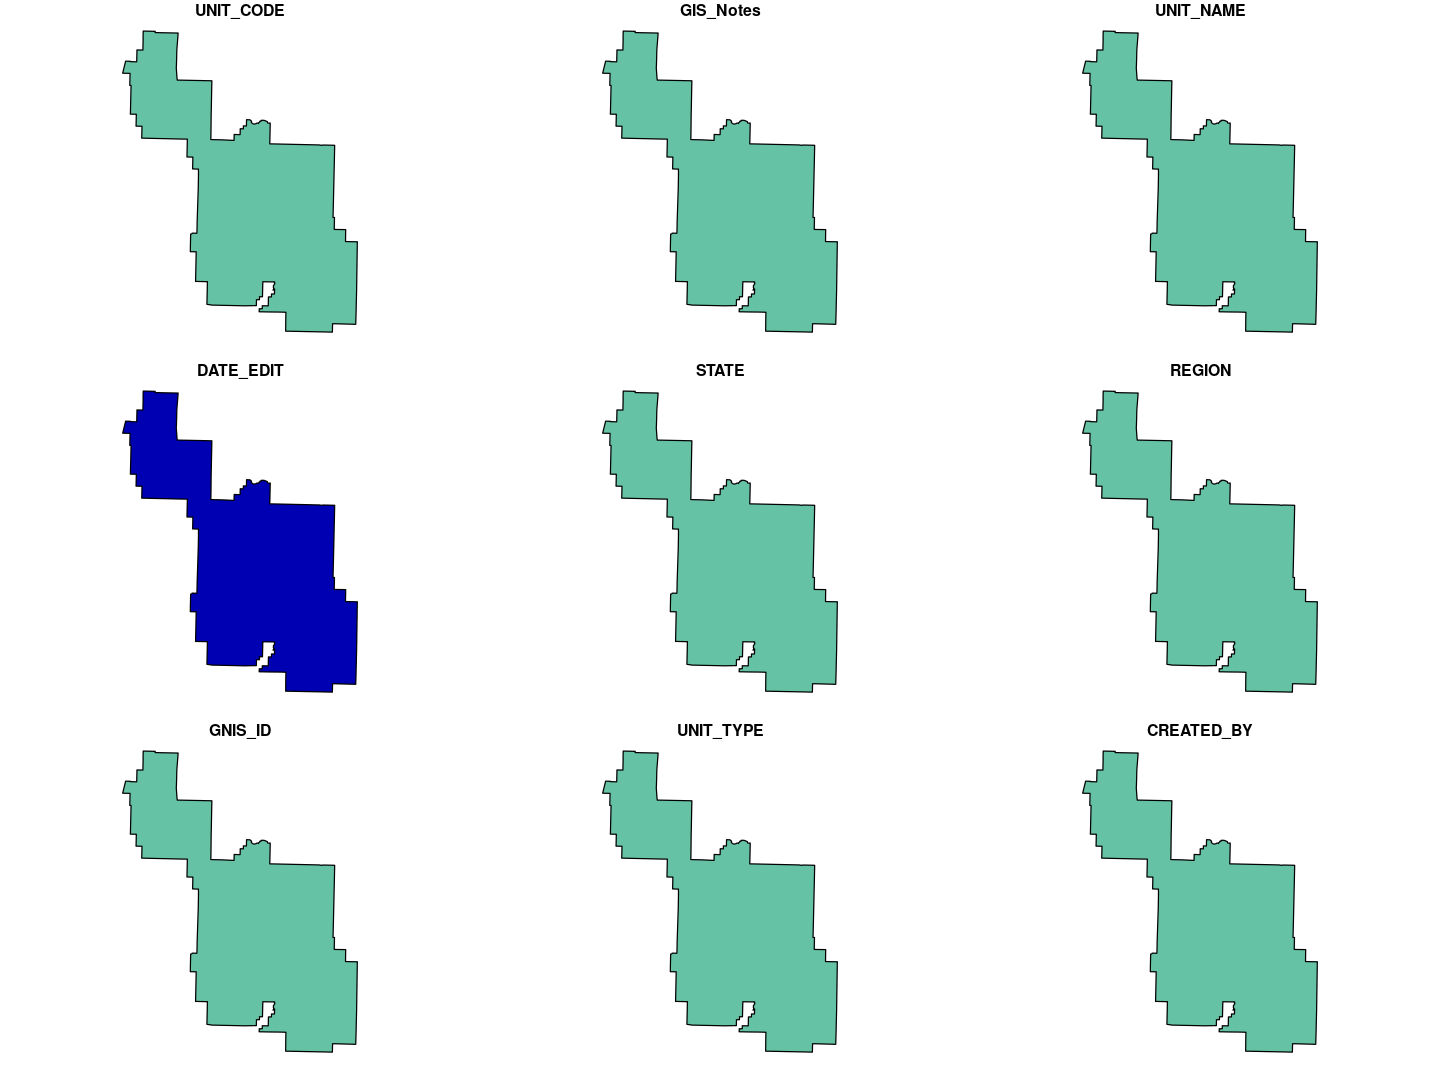

In [38]:
zion = st_read(system.file("vector/zion.gpkg", package = "spDataLarge"))
plot(zion)

We have to make sure that both objects have the same CRS/projection.

In [39]:
zion %>% crs()

Coordinate Reference System:
Deprecated Proj.4 representation:
 +proj=utm +zone=12 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m
+no_defs 
WKT2 2019 representation:
BOUNDCRS[
    SOURCECRS[
        PROJCRS["UTM Zone 12, Northern Hemisphere",
            BASEGEOGCRS["GRS 1980(IUGG, 1980)",
                DATUM["unknown",
                    ELLIPSOID["GRS80",6378137,298.257222101,
                        LENGTHUNIT["metre",1,
                            ID["EPSG",9001]]]],
                PRIMEM["Greenwich",0,
                    ANGLEUNIT["degree",0.0174532925199433]]],
            CONVERSION["UTM zone 12N",
                METHOD["Transverse Mercator",
                    ID["EPSG",9807]],
                PARAMETER["Latitude of natural origin",0,
                    ANGLEUNIT["degree",0.0174532925199433],
                    ID["EPSG",8801]],
                PARAMETER["Longitude of natural origin",-111,
                    ANGLEUNIT["degree",0.0174532925199433],
                    ID

In [40]:
zion = st_transform(zion, crs(srtm))

zion %>% crs()

Coordinate Reference System:
Deprecated Proj.4 representation: +proj=longlat +datum=WGS84 +no_defs 
WKT2 2019 representation:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]] 

**Cropping** reduces the size of the raster object to the smallest rectangle fully including the vector object.

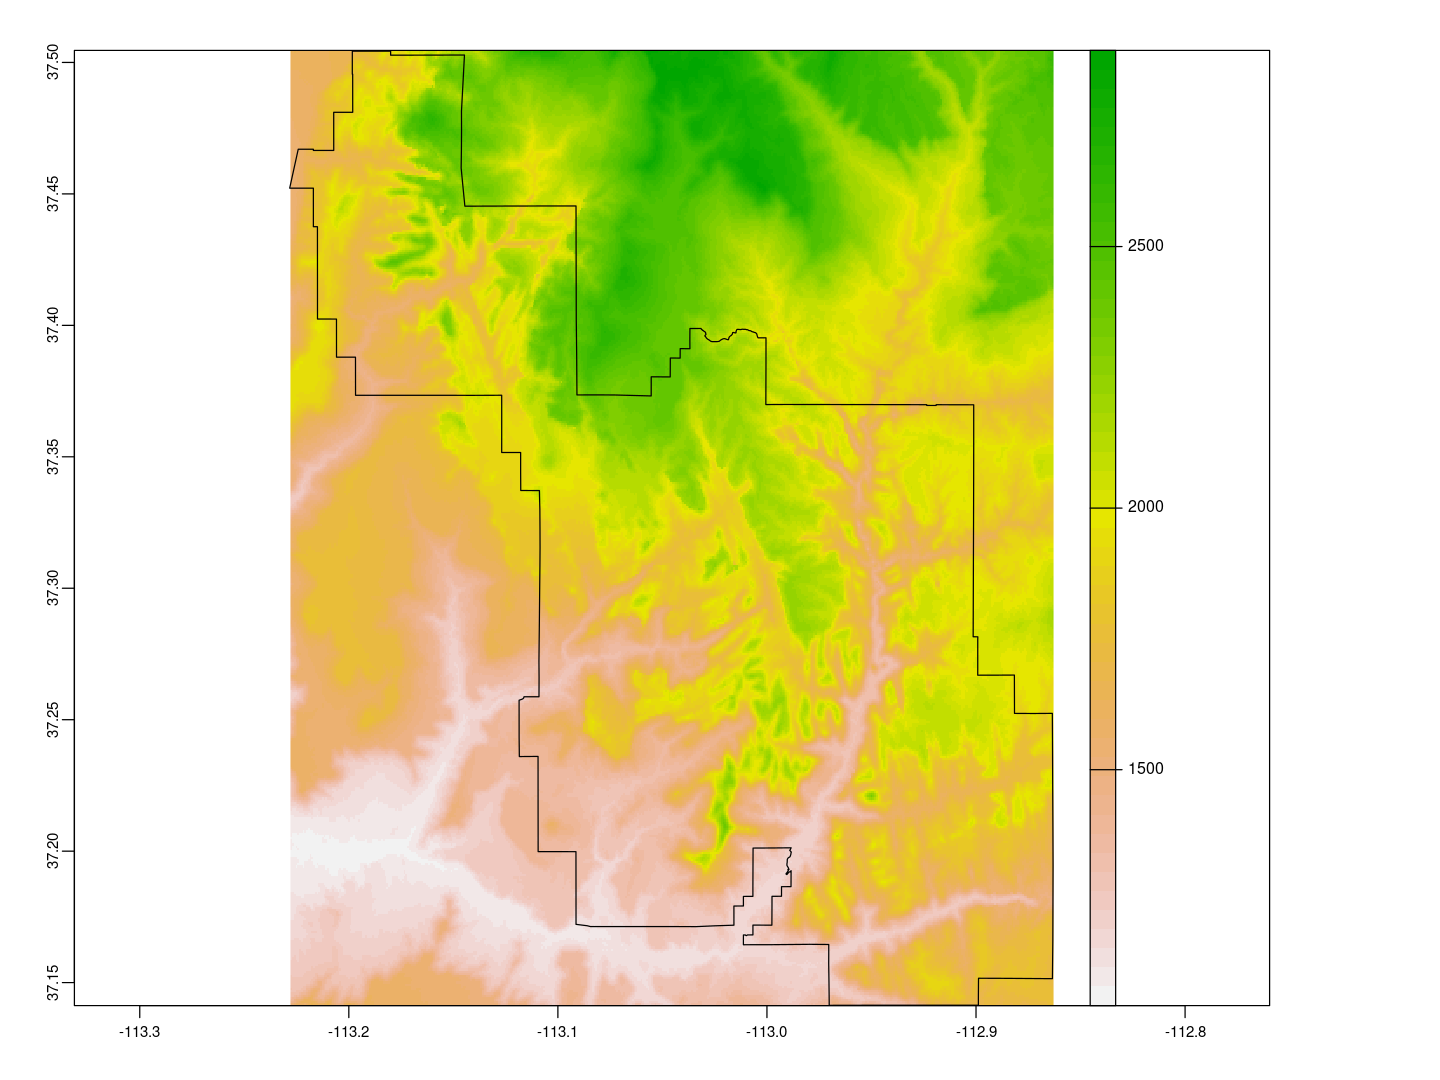

In [41]:
srtm_cropped = crop(srtm, vect(zion))

plot(srtm_cropped)
plot(vect(zion), add=T)

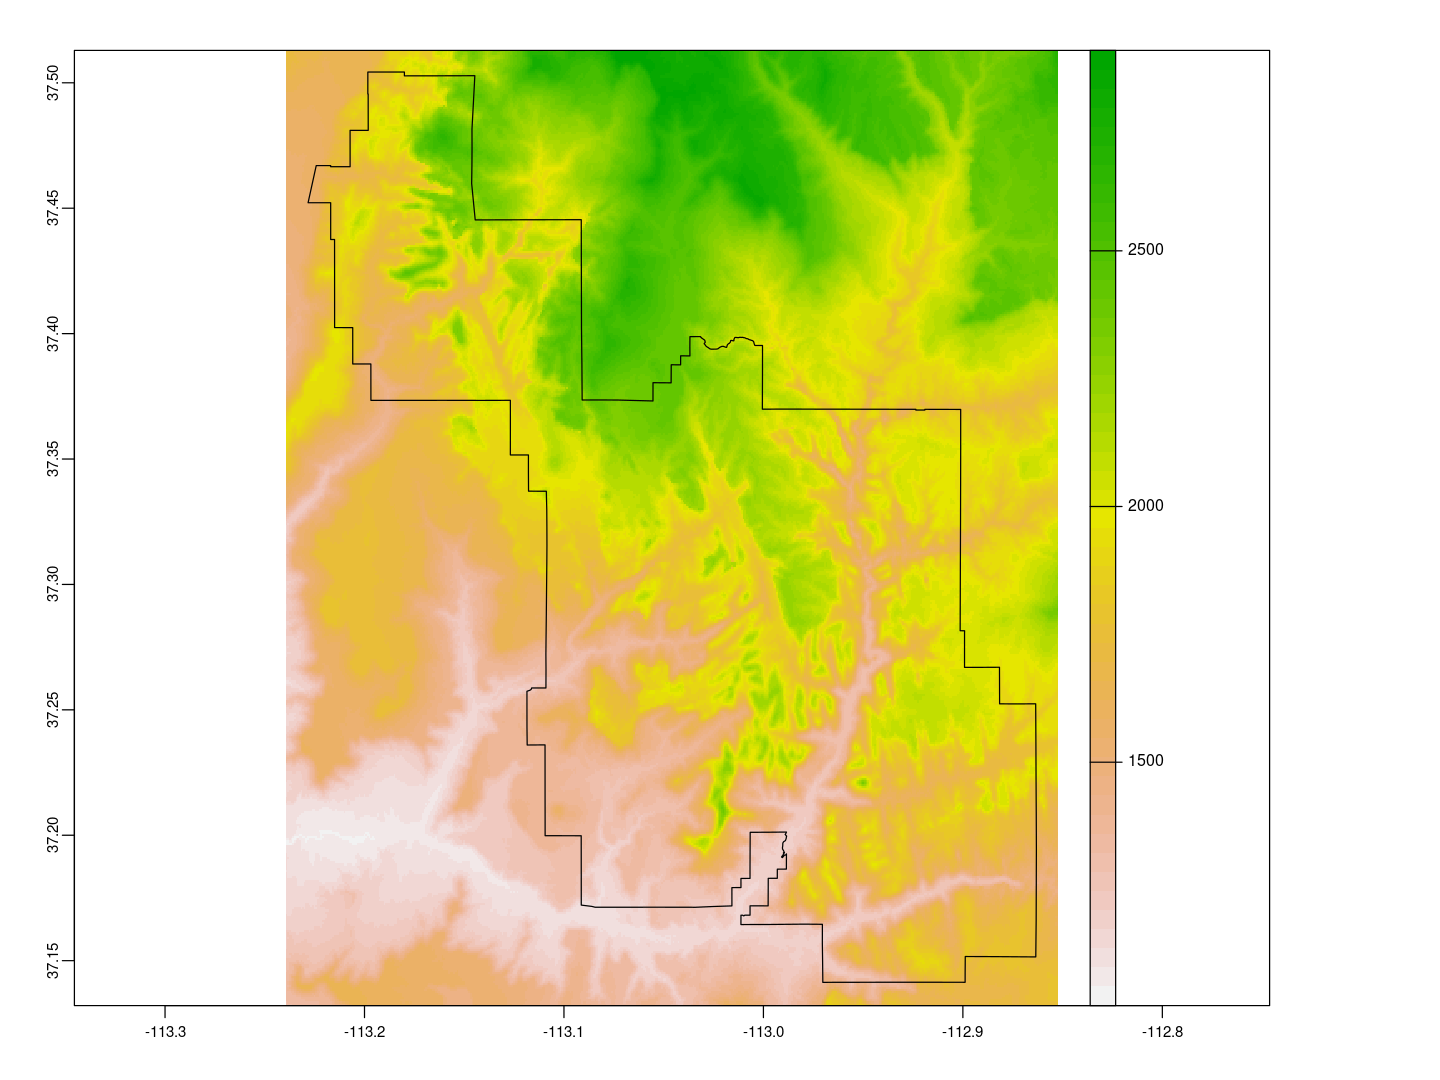

In [42]:
plot(srtm)
plot(vect(zion), add=T)

**Masking** sets all values of the raster object outside the boundaries of the vector object to `NA`.


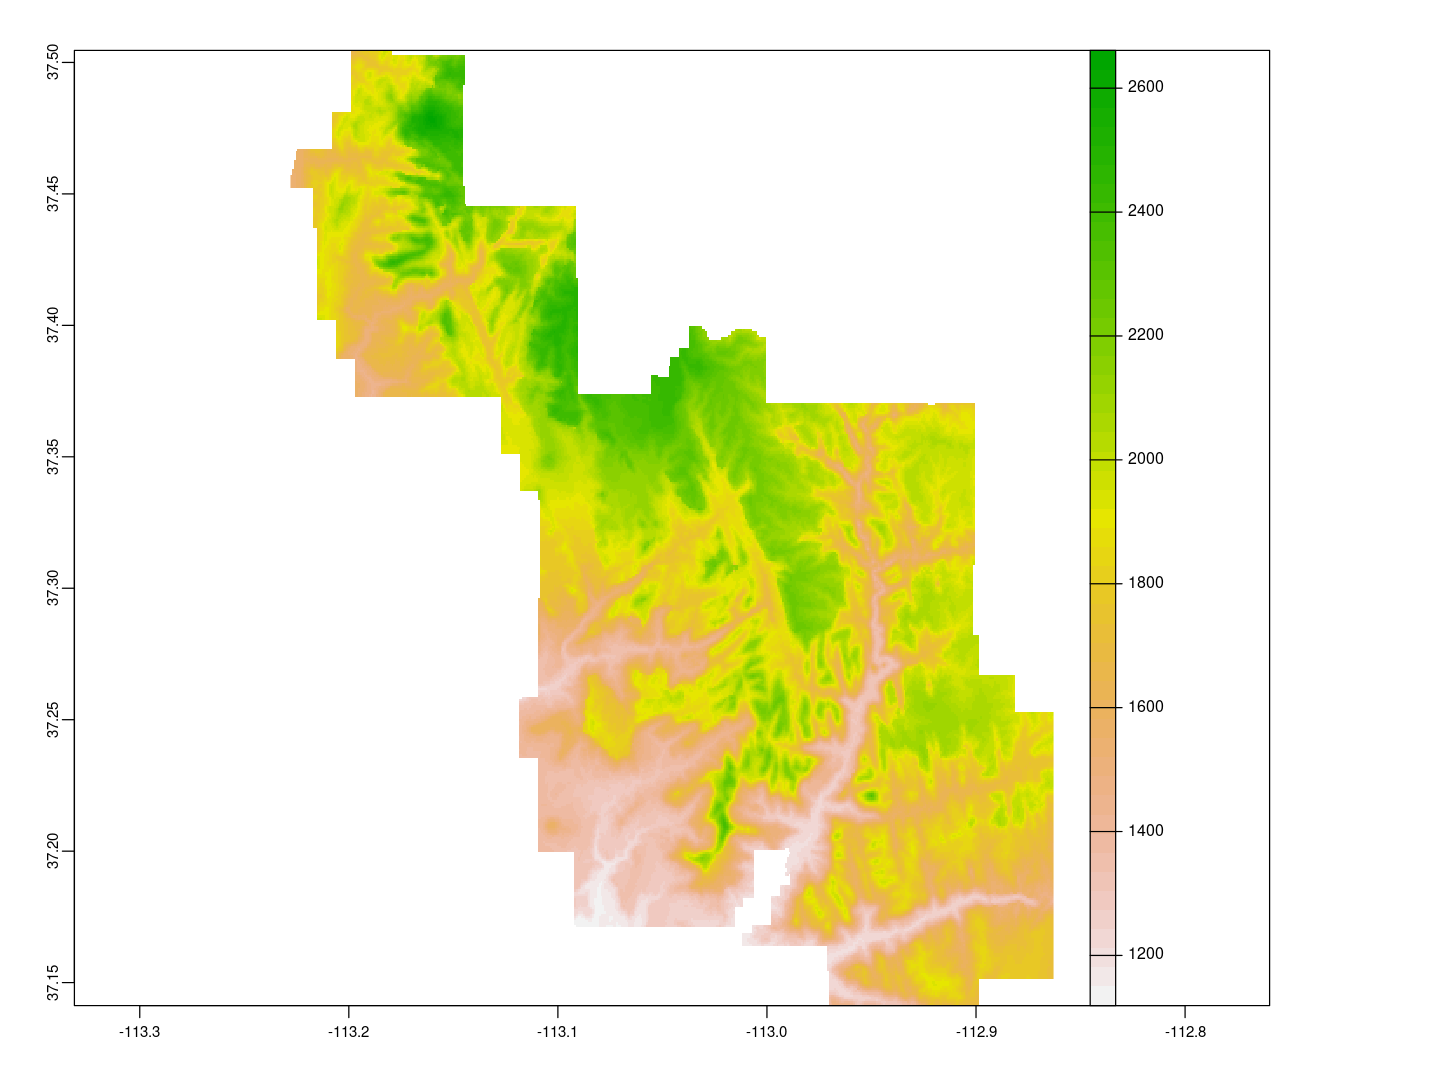

In [43]:
srtm_final = mask(srtm_cropped, vect(zion))
plot(srtm_final)

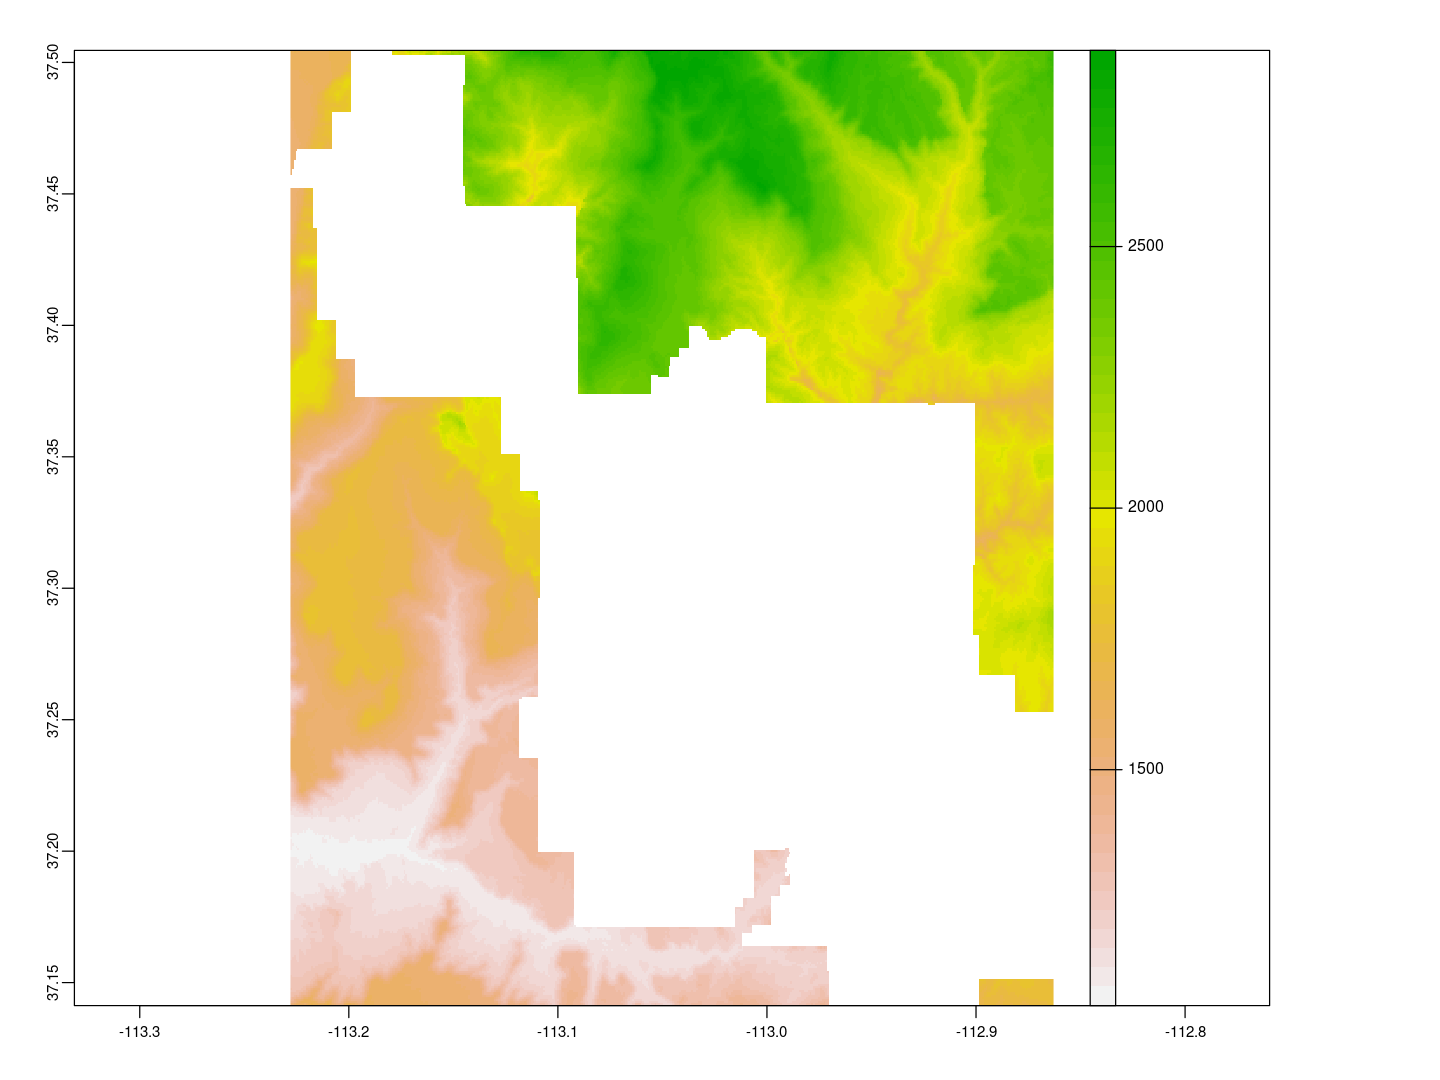

In [44]:
srtm_cropped %>%
    mask(vect(zion), inverse=T) %>%
    plot()

## Raster data file I/O

As for vector data, there is a multitude of file formats for raster data.

The function `rast` from `terra` works with the most common formats.

In [45]:
raster_filepath = system.file("raster/srtm.tif", package = "spDataLarge")
single_layer = rast(raster_filepath)

In [46]:
single_layer

class       : SpatRaster 
dimensions  : 457, 465, 1  (nrow, ncol, nlyr)
resolution  : 0.0008333333, 0.0008333333  (x, y)
extent      : -113.2396, -112.8521, 37.13208, 37.51292  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : srtm.tif 
name        : srtm 
min value   : 1024 
max value   : 2892 

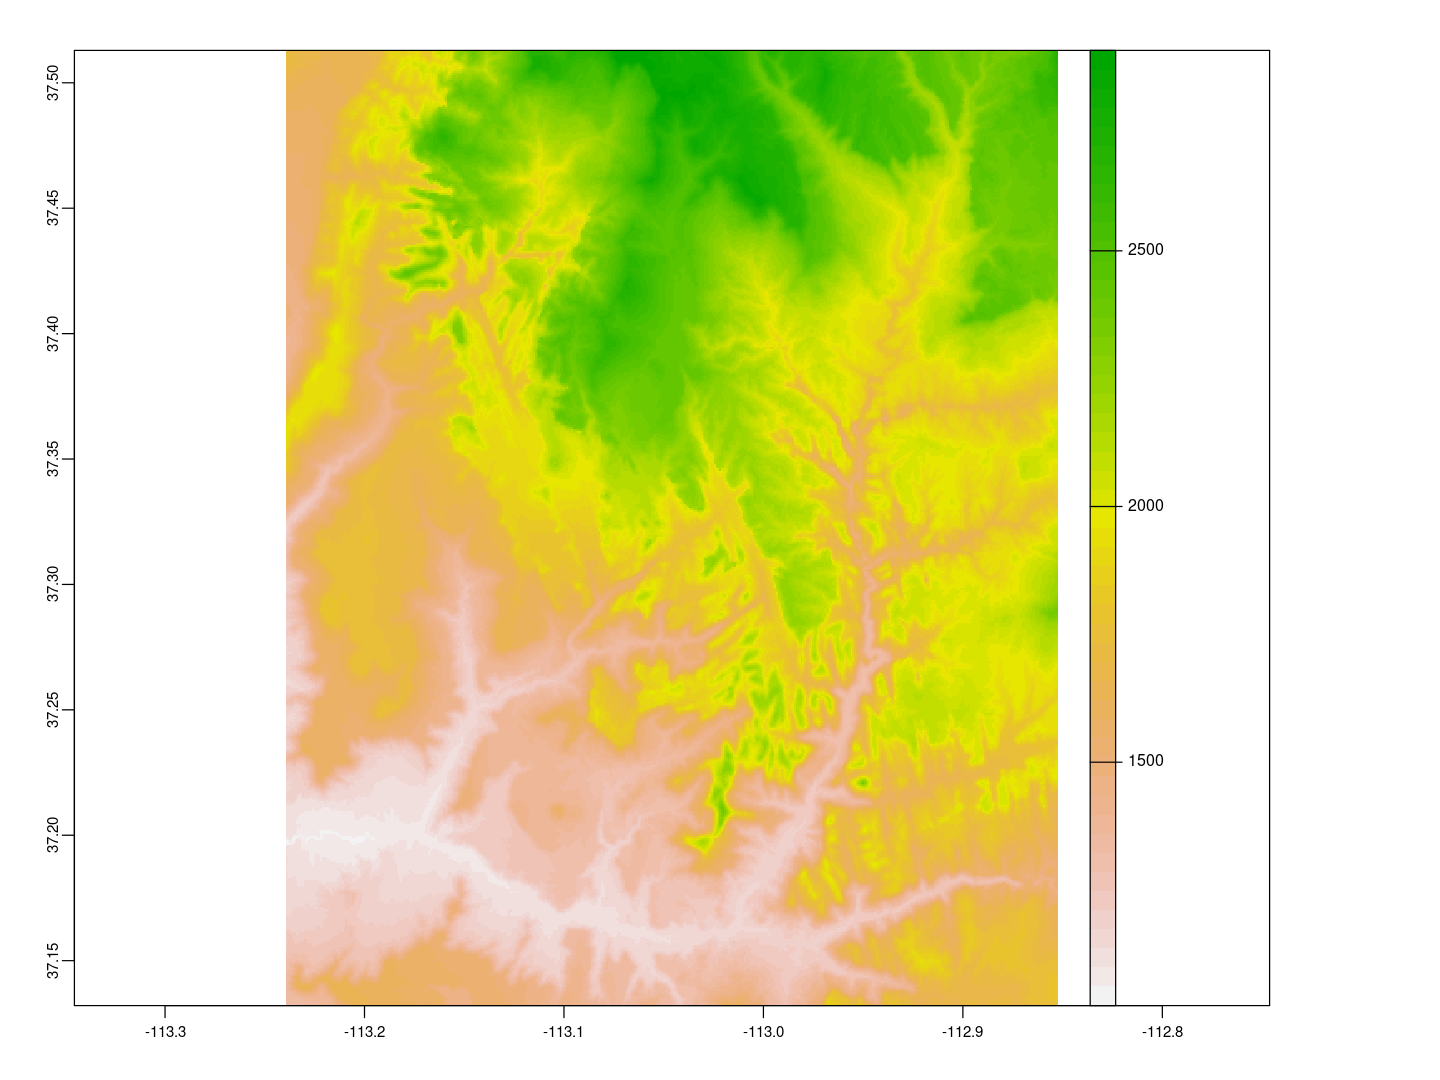

In [47]:
single_layer %>%
    plot()

In [48]:
multilayer_filepath = system.file("raster/landsat.tif", package = "spDataLarge")
multilayer_rast = rast(multilayer_filepath)

multilayer_rast

class       : SpatRaster 
dimensions  : 1428, 1128, 4  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 301905, 335745, 4111245, 4154085  (xmin, xmax, ymin, ymax)
coord. ref. : WGS 84 / UTM zone 12N (EPSG:32612) 
source      : landsat.tif 
names       : lan_1, lan_2, lan_3, lan_4 
min values  :  7550,  6404,  5678,  5252 
max values  : 19071, 22051, 25780, 31961 

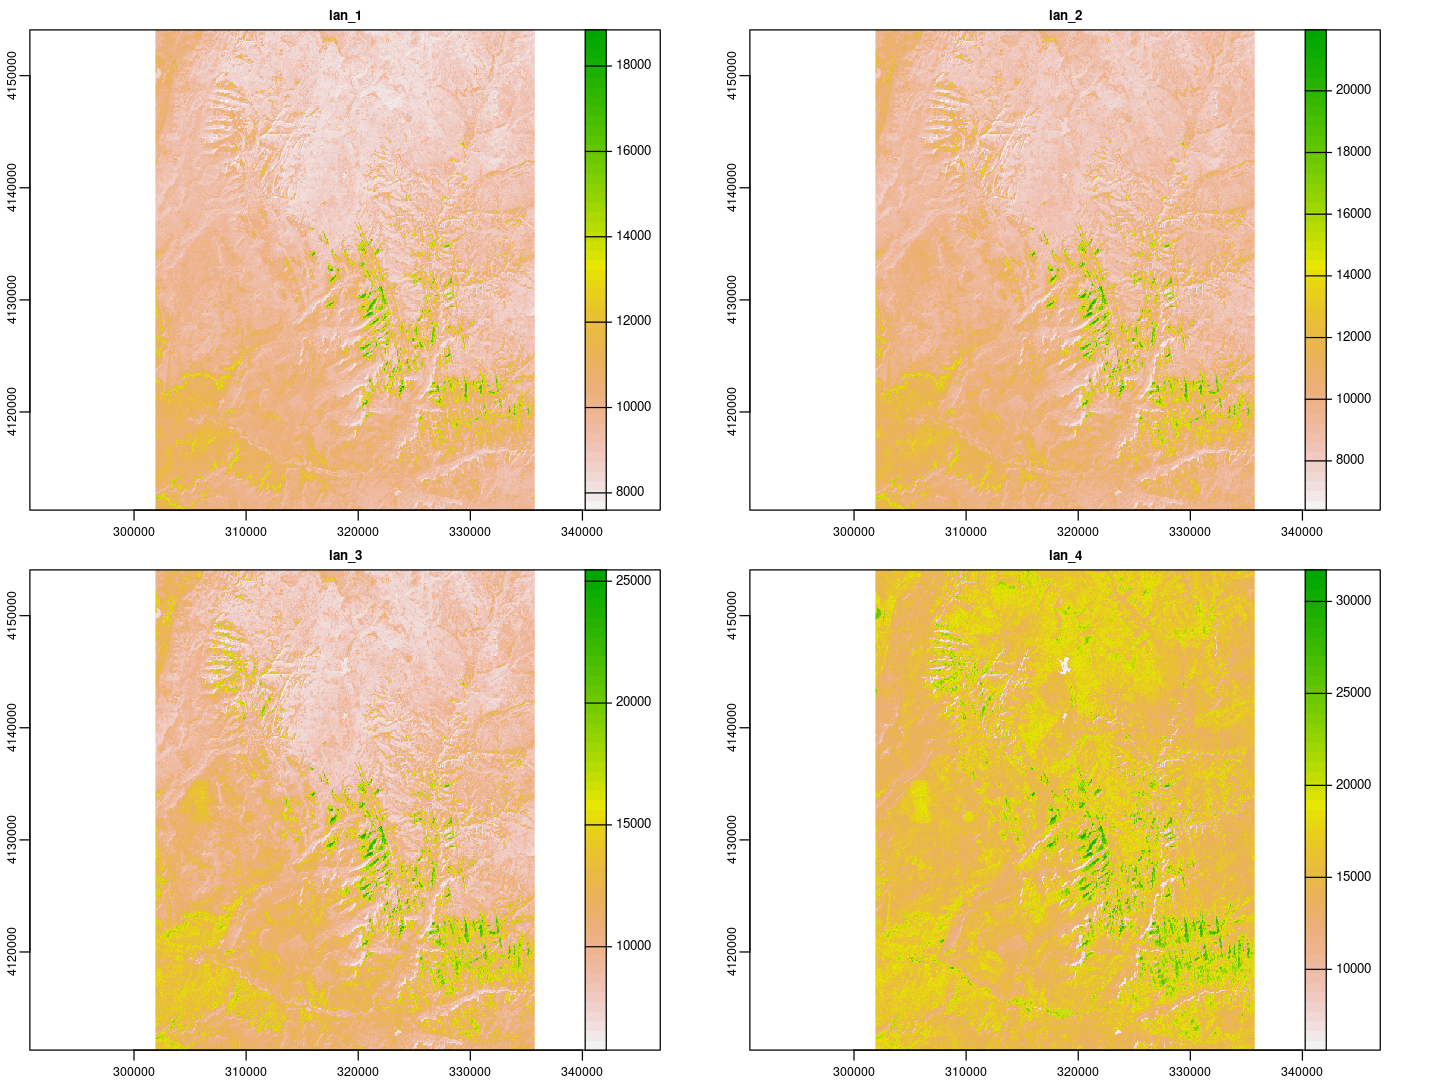

In [49]:
multilayer_rast %>%
    plot()

Raster data can be saved to disk with `writeRaster`; the filename extension - if recognized - determines the output format. 